# Importation des librairies

In [4]:
from pathlib import Path
from random import randrange
from PIL import Image

# Importation des images et masks

In [57]:
IMAGES_DIR_NAME = "images"
MASKS_DIR_NAME = "masks"

images = []
masks = []

# Chemins des fichiers images et masques
image_paths = list(Path(IMAGES_DIR_NAME).iterdir())
mask_paths = list(Path(MASKS_DIR_NAME).iterdir())

# Trier les chemins pour avoir le même indice
image_paths.sort()
mask_paths.sort()

# Parcourir et ouvrir les images et les masques
for image_path, mask_path in zip(image_paths, mask_paths):
    if image_path.name.endswith('.png') and mask_path.name.endswith('.png'):
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        images.append(image)
        masks.append(mask)

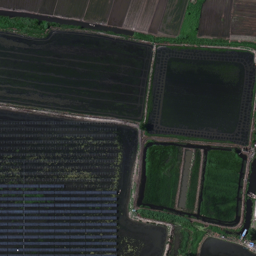

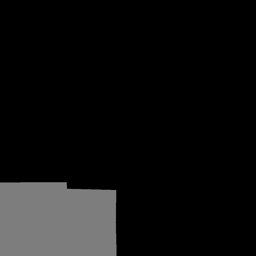

In [75]:
random_indice = randrange(len(images)-1)
display(images[random_indice])
display(masks[random_indice])